In [96]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from util import make_compare_plot,plot_cdf,plot_pdf,convert_type,make_prediction_diff,make_prediction,DCR, hitting_rate, make_clustering
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
import numpy
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt


In [ ]:
# marital-status -> relationship
its_MS = pd.read_csv("generated/strong/ITS/sample_data_1_699_0.csv")

# education-num * 500 = capital-gain
its_linear = pd.read_csv("results/its_sample.csv")

# education-num, age, hours-per-week -> income
its_complex = pd.read_csv("generated/complex/ITS/sample_data_1_699_0.csv")


In [97]:
data = pd.read_csv("adult_train.csv")

# 5% sample of origin data
data_sample = pd.read_csv("adult_train_sample.csv")

# Origin GAN, no fds,no mean loss
origin_GAN = pd.read_csv("generated/strong/origin/sample_data_1_699_0.csv")


strong_num = pd.read_csv("generated/StrongNum/its/itssample_data_1_699_0.csv")
weak_num = pd.read_csv("generated/WeakNum/its/itssample_data_1_699_0.csv")
strong_cate = pd.read_csv("generated/StrongCate/its/itssample_data_1_699_0.csv")
weak_cate = pd.read_csv("generated/WeakCate/its/itssample_data_1_699_0.csv")


baseline_VAE = pd.read_csv("../VAE/expdir/adult/sample_data_vae_699_0.csv")
baseline_VAE.columns = data.columns.tolist()

baseline_tableGAN = pd.read_csv("generated/Adult_OI_11_00_fake.csv",sep=";")
baseline_tableGAN_income = pd.read_csv("generated/tableGAN_income.csv")

baseline_tableGAN["income"] = baseline_tableGAN_income
baseline_tableGAN.columns=origin_GAN.columns


## Visualization

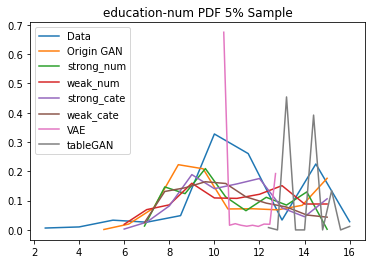

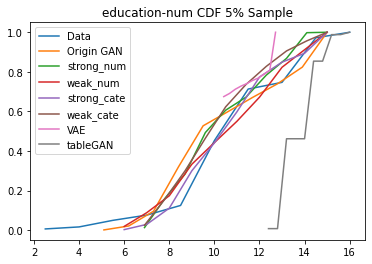

In [100]:
make_compare_plot([data,origin_GAN,strong_num,weak_num,strong_cate,weak_cate,baseline_VAE,baseline_tableGAN],"education-num",plot_pdf,["Data","Origin GAN","strong_num","weak_num","strong_cate","weak_cate","VAE","tableGAN"],"education-num PDF 5% Sample")
make_compare_plot([data,origin_GAN,strong_num,weak_num,strong_cate,weak_cate,baseline_VAE,baseline_tableGAN],"education-num",plot_cdf,["Data","Origin GAN","strong_num","weak_num","strong_cate","weak_cate","VAE","tableGAN"],"education-num CDF 5% Sample")

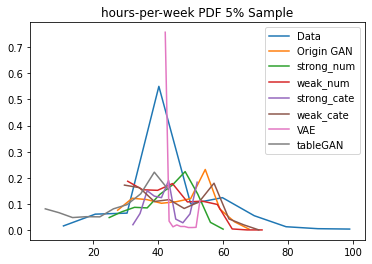

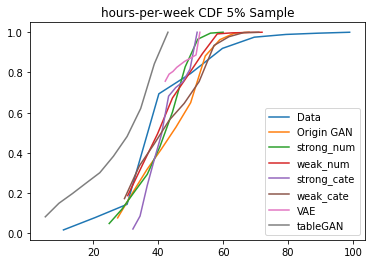

In [101]:
make_compare_plot([data,origin_GAN,strong_num,weak_num,strong_cate,weak_cate,baseline_VAE,baseline_tableGAN],"hours-per-week",plot_pdf,["Data","Origin GAN","strong_num","weak_num","strong_cate","weak_cate","VAE","tableGAN"],"hours-per-week PDF 5% Sample")
make_compare_plot([data,origin_GAN,strong_num,weak_num,strong_cate,weak_cate,baseline_VAE,baseline_tableGAN],"hours-per-week",plot_cdf,["Data","Origin GAN","strong_num","weak_num","strong_cate","weak_cate","VAE","tableGAN"],"hours-per-week CDF 5% Sample")

## Evaluation

In [83]:
strong_num.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,23,Private,144171,HS-grad,8,Never-married,Other-service,Own-child,White,Female,1887,59,38,United-States,<=50K
1,47,State-gov,32894,HS-grad,9,Married-civ-spouse,Other-service,Wife,Black,Female,2702,278,32,United-States,<=50K
2,41,Self-emp-inc,31435,HS-grad,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,1248,954,42,United-States,<=50K
3,43,Self-emp-inc,19241,Masters,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,1371,3003,38,United-States,>50K
4,35,Federal-gov,325524,HS-grad,9,Never-married,Exec-managerial,Own-child,White,Female,1191,11,40,United-States,<=50K


#### Convert data type

In [102]:
data["label"] = "data"
origin_GAN["label"]="origin"


strong_num["label"] = "strong_num"
weak_num["label"] = "weak_num"
strong_cate["label"] = "strong_cate"
weak_cate["label"] = "weak_cate"


baseline_VAE["label"] = "VAE"
baseline_tableGAN["label"] = "table"
data_sample["label"] = "sample"

full = pd.concat([data,data_sample,origin_GAN, strong_num,weak_num,strong_cate,weak_cate,baseline_VAE])
full[['workclass','education', 
       'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country','income']] = convert_type(full,['workclass','education', 
       'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country','income'])

data = full[full["label"] == "data"]
data_sample = full[full["label"] == "sample"]
origin_GAN = full[full["label"] == "origin"]

strong_num = full[full["label"] == "strong_num"]
weak_num = full[full["label"] == "weak_num"]
strong_cate = full[full["label"] == "strong_cate"]
weak_cate = full[full["label"] == "weak_cate"]

baseline_VAE = full[full["label"] == "VAE"]
baseline_table = full[full["label"] == "table"]

In [25]:
# data["income"].to_csv("Adult_rule_modify_label.csv",index=False)
# data_sample.drop(columns=["label","income"]).astype("float64").to_csv("Adult_rule_modify.csv",index=False)

#### Split train and test

In [103]:
origin_np = np.array(data)
col = list(data.columns)
indices = numpy.random.permutation(data.shape[0])
n = data.shape[0] - baseline_VAE.shape[0]
test_idx, training_idx = indices[:n], indices[n:]
training_data, test = pd.DataFrame(origin_np[training_idx,:],columns = col), pd.DataFrame(origin_np[test_idx,:],columns = col)


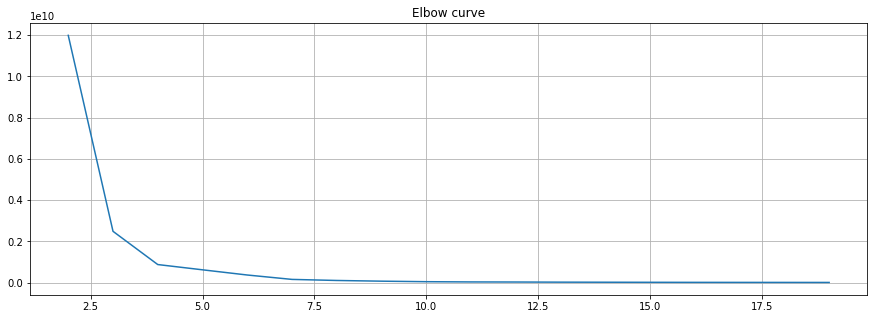

In [104]:
X = training_data.drop(columns=["label","fnlwgt"]).astype("float64")
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)

plt.title('Elbow curve')
plt.show()

In [105]:
dataset = [data_sample,origin_GAN, strong_num,weak_num,strong_cate,weak_cate,baseline_VAE,baseline_tableGAN]

In [106]:
prediction = {}
prediction["age"] = make_prediction("age", "reg",training_data, test,dataset)
prediction["workclass"] = make_prediction("workclass", "clf",training_data, test,dataset)
prediction["education"] = make_prediction("education", "clf",training_data, test,dataset)
prediction["education_num"] = make_prediction("education-num", "clf",training_data, test,dataset)
prediction["marital_status"] = make_prediction("marital-status", "clf",training_data, test,dataset)
prediction["occupation"] = make_prediction("occupation", "clf",training_data, test,dataset)
prediction["relationship"] = make_prediction("relationship", "clf",training_data, test,dataset)
prediction["race"] = make_prediction("race", "clf",training_data, test,dataset)
prediction["sex"] = make_prediction("sex", "clf",training_data, test,dataset)
prediction["capital_gain"] = make_prediction("capital-gain", "reg",training_data, test,dataset)
prediction["capital_loss"] = make_prediction("capital-loss", "reg",training_data, test,dataset)
prediction["hours_per_week"] = make_prediction("hours-per-week", "reg",training_data, test,dataset)
prediction["native_country"] = make_prediction("native-country", "clf",training_data, test,dataset)
#prediction["income"] = make_prediction("income", "clf",training_data, test,dataset)

prediction_diff = {}
prediction_diff["age"] = make_prediction_diff("age", "reg",training_data, test,dataset)
prediction_diff["workclass"] = make_prediction_diff("workclass", "clf",training_data, test,dataset)
prediction_diff["education"] = make_prediction_diff("education", "clf",training_data, test,dataset)
prediction_diff["education_num"] = make_prediction_diff("education-num", "clf",training_data, test,dataset)
prediction_diff["marital_status"] = make_prediction_diff("marital-status", "clf",training_data, test,dataset)
prediction_diff["occupation"] = make_prediction_diff("occupation", "clf",training_data, test,dataset)
prediction_diff["relationship"] = make_prediction_diff("relationship", "clf",training_data, test,dataset)
prediction_diff["race"] = make_prediction_diff("race", "clf",training_data, test,dataset)
prediction_diff["sex"] = make_prediction_diff("sex", "clf",training_data, test,dataset)
prediction_diff["capital_gain"] = make_prediction_diff("capital-gain", "reg",training_data, test,dataset)
prediction_diff["capital_loss"] = make_prediction_diff("capital-loss", "reg",training_data, test,dataset)
prediction_diff["hours_per_week"] = make_prediction_diff("hours-per-week", "reg",training_data, test,dataset)
prediction_diff["native_country"] = make_prediction_diff("native-country", "clf",training_data, test,dataset)
#prediction_diff["income"] = make_prediction_diff("income", "clf",training_data, test,dataset)

### Machine Learning utils

In [107]:
pd.DataFrame(prediction,index=["ground Truth","Sample 5%","Origin GAN","Strong-Num","Weak-Num","Strong-Cate","Weak-Cate","VAE","tableGAN"])

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
ground Truth,0.284150,0.710869,0.997975,0.999721,0.817674,0.273594,0.755211,0.849377,0.824692,-0.829429,-0.316430,0.000057,0.911246
Sample 5%,0.298865,0.717643,0.997661,0.999965,0.829126,0.306903,0.770434,0.863517,0.834678,-0.667291,-0.319104,0.048046,0.912713
Origin GAN,0.046979,0.631752,0.434098,0.067630,0.679306,0.140638,0.618798,0.829859,0.698265,-9.760680,-1.593502,-0.239482,0.784819
Strong-Num,-0.130964,0.667819,0.334171,0.245662,0.572152,0.128452,0.489613,0.764813,0.690164,-3.507340,-0.674121,-0.074523,0.901470
Weak-Num,-0.029405,0.681540,0.291575,0.188436,0.664223,0.135680,0.612583,0.818756,0.684613,-2.866872,-8.075307,-0.358910,0.864216
Strong-Cate,-0.486175,0.726651,0.381865,0.153905,0.723648,0.148179,0.451660,0.854195,0.555462,-5.189986,-3.011885,0.063160,0.909431
Weak-Cate,-0.310680,0.679795,0.396948,0.115638,0.635837,0.129220,0.544150,0.775357,0.677944,-4.716638,-1.089600,-0.441501,0.892357
VAE,-0.084394,NaN,0.480675,NaN,0.642750,0.267169,0.569289,NaN,0.738906,0.020800,-0.050313,-0.063672,NaN
tableGAN,-2.166846,0.050312,0.029992,0.149785,0.313921,0.061765,0.210049,NaN,0.587933,-0.007890,-0.047779,-1.838247,NaN


In [108]:
pd.DataFrame(prediction_diff,index=["ground Truth","Sample 5%","Origin GAN","Strong-Num","Weak-Num","Strong-Cate","Weak-Cate","VAE","tableGAN"])

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
ground Truth,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sample 5%,0.014715,0.006774,0.000314,0.000244,0.011452,0.033309,0.015223,0.014141,0.009986,0.162138,0.002675,0.047989,0.001466
Origin GAN,0.237171,0.079117,0.563877,0.932090,0.138368,0.132956,0.136413,0.019517,0.126427,8.931251,1.277072,0.239539,0.126427
Strong-Num,0.415114,0.043050,0.663804,0.754059,0.245522,0.145142,0.265598,0.084564,0.134527,2.677911,0.357692,0.074580,0.009776
Weak-Num,0.313555,0.029329,0.706400,0.811285,0.153451,0.137914,0.142628,0.030620,0.140079,2.037443,7.758877,0.358968,0.047030
Strong-Cate,0.770325,0.015782,0.616110,0.845815,0.094026,0.125415,0.303551,0.004818,0.269229,4.360557,2.695456,0.063102,0.001816
Weak-Cate,0.594830,0.031074,0.601027,0.884082,0.181837,0.144373,0.211061,0.074020,0.146748,3.887208,0.773170,0.441558,0.018889
VAE,0.368545,NaN,0.517300,NaN,0.174924,0.006424,0.185922,NaN,0.085786,0.850229,0.266117,0.063730,NaN
tableGAN,2.450996,0.660557,0.967983,0.849935,0.503753,0.211829,0.545163,NaN,0.236758,0.821539,0.268651,1.838304,NaN


### Clustering

In [112]:
from sklearn.cluster import KMeans
pd.DataFrame(make_clustering(training_data,test,dataset),index=["ground Truth","Sample 5%","Origin GAN","Strong-Num","Weak-Num","Strong-Cate","Weak-Cate","VAE","tableGAN"],columns=["Clustering NMI"])

,Clustering NMI
ground Truth,1.000000
Sample 5%,0.852969
Origin GAN,0.573900
Strong-Num,0.571154
Weak-Num,0.492747
Strong-Cate,0.492747
Weak-Cate,0.559165
VAE,0.564171
tableGAN,0.651389


### Approximate query processing (AQP)

AQP 
* http://dbgroup.cs.tsinghua.edu.cn/ligl/baq.pdf 
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9101822


### Privacy protection

#### Hitting Rate & DCR

In [113]:
similar = hitting_rate(dataset)

500it [00:31, 15.81it/s]
500it [00:32, 15.45it/s]
500it [00:32, 15.43it/s]
500it [00:31, 16.06it/s]
500it [00:32, 15.41it/s]
500it [00:32, 15.37it/s]
500it [00:32, 15.34it/s]


In [114]:
maxi,mini = DCR(dataset)


In [115]:
pd.DataFrame(np.array([similar,maxi,mini]).T,index=["Origin GAN","Strong-Num","Weak-Num","Strong-Cate","Weak-Cate","VAE","tableGAN"],columns=["Exactly Same data (Categorical)","Distance to the furthest record","Distance to the closest record"])

,Exactly Same data (Categorical),Distance to the furthest record,Distance to the closest record
Origin GAN,28.0,2.567465,0.065726
Strong-Num,11.0,2.549097,0.087108
Weak-Num,11.0,2.535447,0.069357
Strong-Cate,53.0,2.622539,0.021771
Weak-Cate,12.0,2.504538,0.025054
VAE,0.0,2.276016,0.042216
tableGAN,0.0,2.510330,0.336226
